In [0]:
%reload_ext autoreload 
%autoreload 2 
%matplotlib inline 

In [1]:
import os, shutil
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from google.colab import files
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alessandropontini","key":"33ef5bfa540b43b3805a776d6617b263"}'}

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [7]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 4.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=c4cd019414d18ff68d359d354bce1fcdde9585ccf7f69253e4f50444b78e2bad
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6


In [8]:
!kaggle competitions list -s dogs

ref                                 deadline             category       reward  teamCount  userHasEntered  
----------------------------------  -------------------  ----------  ---------  ---------  --------------  
dogs-vs-cats                        2014-02-01 23:59:00  Playground       Swag        215            True  
dogs-vs-cats-redux-kernels-edition  2017-03-02 23:59:00  Playground  Knowledge       1314           False  


In [9]:
!kaggle competitions download -c dogs-vs-cats

 99% 800M/812M [00:10<00:00, 70.5MB/s]
100% 812M/812M [00:10<00:00, 80.3MB/s]


In [10]:
! unzip /content/dogs-vs-cats.zip -d /content/dogs-vs-cats

Archive:  /content/dogs-vs-cats.zip
  inflating: /content/dogs-vs-cats/sampleSubmission.csv  
  inflating: /content/dogs-vs-cats/test1.zip  
  inflating: /content/dogs-vs-cats/train.zip  


In [11]:
! unzip /content/dogs-vs-cats/test1.zip -d /content/dogs-vs-cats/test1
! unzip /content/dogs-vs-cats/train.zip  -d /content/dogs-vs-cats/train

Streaming output truncated to the last 5000 lines.
  inflating: /content/dogs-vs-cats/train/train/dog.55.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.550.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5500.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5501.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5502.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5503.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5504.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5505.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5506.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5507.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5508.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5509.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.551.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5510.jpg  
  inflating: /content/dogs-vs-cats/train/train/dog.5511.jpg  
  inflating: /content/d

In [0]:
import pandas as pd
filenames = os.listdir("/content/dogs-vs-cats/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df

,filename,category
0,dog.11529.jpg,1
1,dog.3282.jpg,1
2,cat.8551.jpg,0
3,dog.5078.jpg,1
4,cat.4626.jpg,0
...,...,...
24995,cat.9326.jpg,0
24996,cat.3045.jpg,0
24997,dog.9009.jpg,1
24998,dog.10487.jpg,1


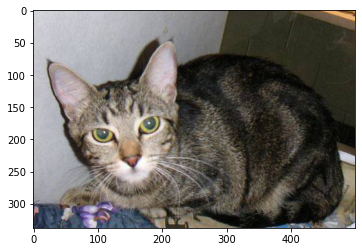

In [5]:
dir_train = "/content/dogs-vs-cats/train/train/"
dir_test = "/content/dogs-vs-cats/test1/test1"



sample = random.choice(filenames)
image = load_img(dir_train+sample)
plt.imshow(image)

In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20

In [0]:

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]


In [10]:
FAST_RUN = False
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
# data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    dir_train, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    dir_train, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [12]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    dir_train, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


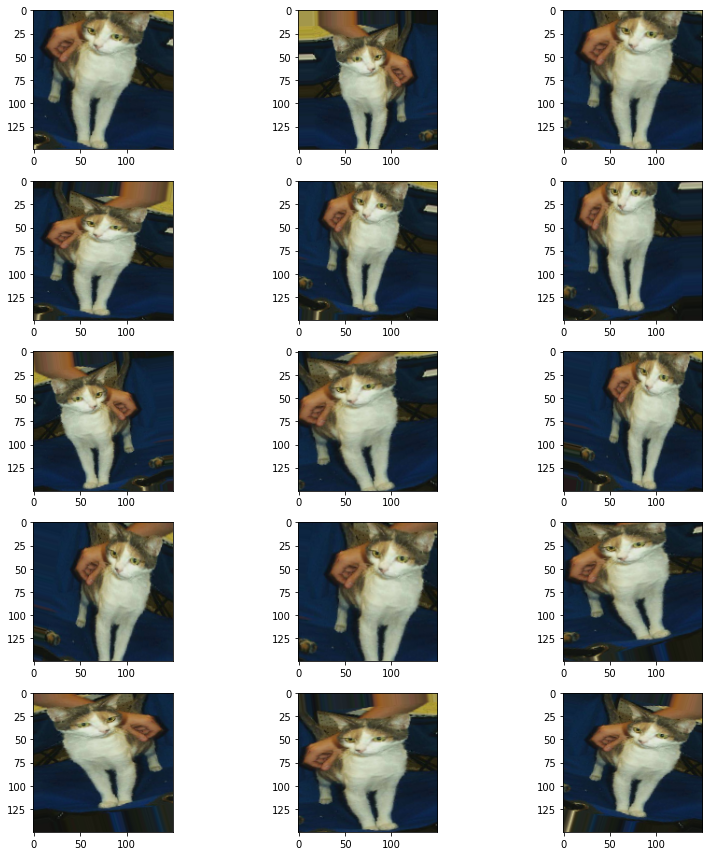

In [13]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

APPROCCIO FEATURE EXTRACTION 

In [32]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [0]:
# freeze layer
conv_base.trainable = False

In [39]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator( train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks)

Epoch 1/30
100/100 [==============================] - 24s 236ms/step - loss: 0.5772 - acc: 0.7125 - val_loss: 0.4661 - val_acc: 0.8390
Epoch 2/30
100/100 [==============================] - 17s 170ms/step - loss: 0.4407 - acc: 0.8177 - val_loss: 0.2684 - val_acc: 0.8325
Epoch 3/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3922 - acc: 0.8360 - val_loss: 0.2304 - val_acc: 0.8660
Epoch 4/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3711 - acc: 0.8388 - val_loss: 0.2557 - val_acc: 0.8700
Epoch 5/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3530 - acc: 0.8470 - val_loss: 0.3486 - val_acc: 0.8735
Epoch 6/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3418 - acc: 0.8535 - val_loss: 0.3697 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 17s 172ms/step - loss: 0.3320 - acc: 0.8630 - val_loss: 0.2509 - val_acc: 0.8810
Epoch 8/30
100/100 [==============================] - 1

In [0]:
model.save("VGG16_notuning")

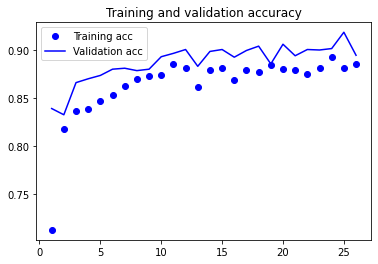

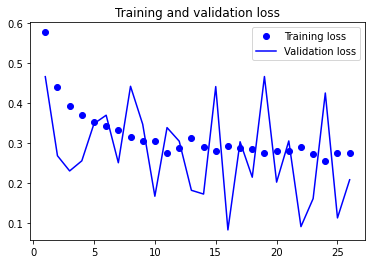

In [41]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# resnet
from keras.applications import ResNet50

In [49]:
conv_base2 = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
model = models.Sequential()
model.add(conv_base2)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [0]:
# freeze layer
conv_base.trainable = False

In [52]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator( train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks)

Epoch 1/30
100/100 [==============================] - 36s 363ms/step - loss: 0.3364 - acc: 0.8583 - val_loss: 0.8469 - val_acc: 0.5010
Epoch 2/30
100/100 [==============================] - 22s 223ms/step - loss: 0.2175 - acc: 0.9143 - val_loss: 1.3411 - val_acc: 0.5095
Epoch 3/30
100/100 [==============================] - 22s 225ms/step - loss: 0.1792 - acc: 0.9293 - val_loss: 1.1486 - val_acc: 0.4960
Epoch 4/30
100/100 [==============================] - 22s 224ms/step - loss: 0.1571 - acc: 0.9373 - val_loss: 1.8738 - val_acc: 0.4900

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 5/30
100/100 [==============================] - 22s 222ms/step - loss: 0.1533 - acc: 0.9350 - val_loss: 0.8494 - val_acc: 0.5610
Epoch 6/30
100/100 [==============================] - 22s 225ms/step - loss: 0.1260 - acc: 0.9495 - val_loss: 0.8780 - val_acc: 0.6600
Epoch 7/30
100/100 [==============================] - 22s 221ms/step - loss: 0.1387 - acc: 0.9463 - val_loss: 0.4839 - val_ac

In [0]:
model.save("resnet50_notuning")

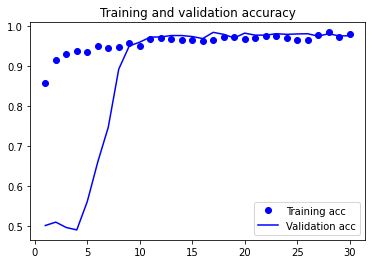

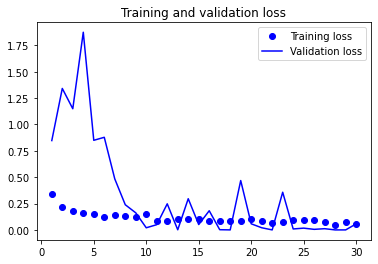

In [54]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

FINE TUNING

In [0]:
conv_base2.summary()

In [0]:
list_train = ["res5c_branch2a", "res5c_branch2b", "res5c_branch2c"]
conv_base2.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name in list_train:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [59]:
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 216


In [60]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5),
                      metrics=['acc'])

history2 = model.fit_generator( train_generator,
              steps_per_epoch=100,
              epochs=100,
              validation_data=validation_generator,
              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 37s 371ms/step - loss: 0.0502 - acc: 0.9858 - val_loss: 1.5084e-04 - val_acc: 0.9775
Epoch 2/100
100/100 [==============================] - 23s 226ms/step - loss: 0.0488 - acc: 0.9837 - val_loss: 0.1278 - val_acc: 0.9850
Epoch 3/100
100/100 [==============================] - 22s 225ms/step - loss: 0.0699 - acc: 0.9783 - val_loss: 0.2135 - val_acc: 0.9805
Epoch 4/100
100/100 [==============================] - 23s 226ms/step - loss: 0.0679 - acc: 0.9822 - val_loss: 0.1598 - val_acc: 0.9765
Epoch 5/100
100/100 [==============================] - 22s 223ms/step - loss: 0.0509 - acc: 0.9808 - val_loss: 0.0120 - val_acc: 0.9775
Epoch 6/100
100/100 [==============================] - 22s 225ms/step - loss: 0.0592 - acc: 0.9805 - val_loss: 0.0024 - val_acc: 0.9850
Epoch 7/100
100/100 [==============================] - 22s 222ms/step - loss: 0.0573 - acc: 0.9825 - val_loss: 0.3525 - val_acc: 0.9815
Epoch 8/100
100/100 [=======================

In [0]:
model.save("resnet50_tuning_last_blocklayer")

In [1]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

TEST

In [0]:
from keras.models import load_model
model = load_model('resnet50_tuning_last_blocklayer')

In [0]:
model.save_weights("model_submission.h5")

In [0]:
test_filenames = os.listdir(dir_test)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [17]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    dir_test, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
predict = model.predict_generator(test_generator)

In [24]:
len(predict)

12500

In [25]:
test_df

,filename
0,712.jpg
1,552.jpg
2,5678.jpg
3,668.jpg
4,3621.jpg
...,...
12495,4198.jpg
12496,82.jpg
12497,7671.jpg
12498,5499.jpg


In [0]:
test_df['category'] = np.argmax(predict, axis=-1)

In [27]:
test_df.head()

,filename,category
0,712.jpg,1
1,552.jpg,1
2,5678.jpg,1
3,668.jpg,1
4,3621.jpg,1


In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [29]:
test_df

,filename,category
0,712.jpg,dog
1,552.jpg,dog
2,5678.jpg,dog
3,668.jpg,dog
4,3621.jpg,dog
...,...,...
12495,4198.jpg,dog
12496,82.jpg,cat
12497,7671.jpg,dog
12498,5499.jpg,cat


In [0]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [31]:
test_df

,filename,category
0,712.jpg,1
1,552.jpg,1
2,5678.jpg,1
3,668.jpg,1
4,3621.jpg,1
...,...,...
12495,4198.jpg,1
12496,82.jpg,0
12497,7671.jpg,1
12498,5499.jpg,0


In [34]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(dir_test+"/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
test_df

,filename
0,712.jpg
1,552.jpg
2,5678.jpg
3,668.jpg
4,3621.jpg
...,...
12495,4198.jpg
12496,82.jpg
12497,7671.jpg
12498,5499.jpg


SUBMISSION KAGGLE

In [0]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [36]:
submission_df

,id,label
0,712,1
1,552,1
2,5678,1
3,668,1
4,3621,1
...,...,...
12495,4198,1
12496,82,0
12497,7671,1
12498,5499,0


In [4]:
! kaggle competitions submit -c dogs-vs-cats -f submission.csv -m "First Competition Submission :)!"

100% 86.8k/86.8k [00:01<00:00, 64.2kB/s]
Could not find competition - please verify that you entered the correct competition ID and that the competition is still accepting submissions.


APPROCCIO CLASSICO CNN


In [0]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [0]:
history = model.fit_generator( 
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 19s 189ms/step - loss: 0.6923 - acc: 0.5278 - val_loss: 0.6531 - val_acc: 0.4920
Epoch 2/30
100/100 [==============================] - 16s 163ms/step - loss: 0.6788 - acc: 0.5763 - val_loss: 0.6467 - val_acc: 0.5850
Epoch 3/30
100/100 [==============================] - 16s 164ms/step - loss: 0.6692 - acc: 0.5920 - val_loss: 0.4841 - val_acc: 0.6145
Epoch 4/30
100/100 [==============================] - 16s 161ms/step - loss: 0.6541 - acc: 0.6233 - val_loss: 0.5405 - val_acc: 0.6375
Epoch 5/30
100/100 [==============================] - 16s 162ms/step - loss: 0.6484 - acc: 0.6233 - val_loss: 0.7058 - val_acc: 0.6575
Epoch 6/30
100/100 [==============================] - 16s 162ms/step - loss: 0.6249 - acc: 0.6612 - val_loss: 0.4940 - val_acc: 0.6770
Epoch 7/30
100/100 [==============================] - 16s 164ms/step - loss: 0.6199 - acc: 0.6560 - val_loss: 0.4217 - val_acc: 0.6935
Epoch 8/30
100/100 [==============================] - 1

In [0]:
model.save('cats_and_dogs_model1')

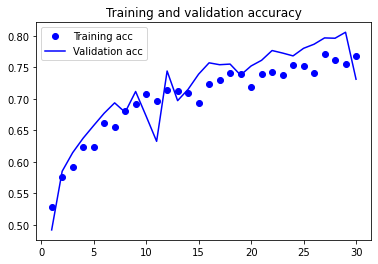

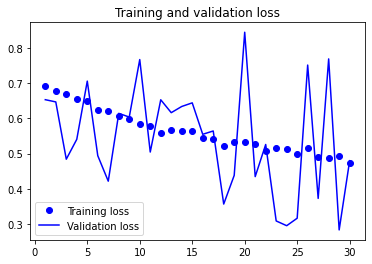

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# PROVO MODELLO 2

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/100
100/100 [==============================] - 15s 155ms/step - loss: 0.6930 - acc: 0.5145 - val_loss: 0.7007 - val_acc: 0.5788
Epoch 2/100
100/100 [==============================] - 15s 152ms/step - loss: 0.6786 - acc: 0.5648 - val_loss: 0.6045 - val_acc: 0.5650
Epoch 3/100
100/100 [==============================] - 15s 148ms/step - loss: 0.6730 - acc: 0.5788 - val_loss: 0.5720 - val_acc: 0.6250
Epoch 4/100
100/100 [==============================] - 15s 150ms/step - loss: 0.6610 - acc: 0.6047 - val_loss: 0.5957 - val_acc: 0.6513
Epoch 5/100
100/100 [==============================] - 15s 150ms/step - loss: 0.6518 - acc: 0.6083 - val_loss: 0.5621 - val_acc: 0.6625
Epoch 6/100
100/100 [==============================] - 15s 150ms/step - loss: 0.6307 - acc: 0.6463 - val_loss: 0.5960 - val_acc: 0.6737
Epoch 7/100
100/100 [==============================] - 15s 149ms/step - loss: 0.6278 - acc: 0.6428 - val_loss: 0.6902 - val_acc: 0.6300
Epoch 8/100
100/100 [===========================

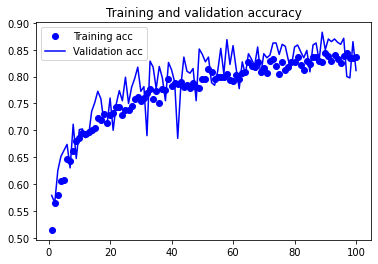

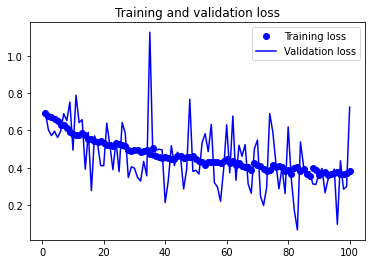

In [0]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# PROVO MODELLO 3

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 15, 15, 128)      

In [0]:
history3 = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=20,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 17s 169ms/step - loss: 0.6942 - acc: 0.4960 - val_loss: 0.6920 - val_acc: 0.5850
Epoch 2/100
100/100 [==============================] - 15s 151ms/step - loss: 0.6923 - acc: 0.5123 - val_loss: 0.6886 - val_acc: 0.5625
Epoch 3/100
100/100 [==============================] - 15s 152ms/step - loss: 0.6888 - acc: 0.5518 - val_loss: 0.7243 - val_acc: 0.5100

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/100
100/100 [==============================] - 15s 152ms/step - loss: 0.6819 - acc: 0.5700 - val_loss: 0.6303 - val_acc: 0.5800
Epoch 5/100
100/100 [==============================] - 15s 152ms/step - loss: 0.6752 - acc: 0.5838 - val_loss: 0.6368 - val_acc: 0.5900
Epoch 6/100
100/100 [==============================] - 15s 151ms/step - loss: 0.6704 - acc: 0.5938 - val_loss: 0.6410 - val_acc: 0.6850
Epoch 7/100
100/100 [==============================] - 15s 152ms/step - loss: 0.6532 - acc: 0.6332 - va

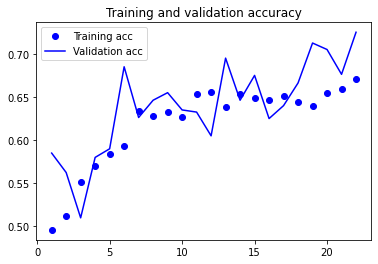

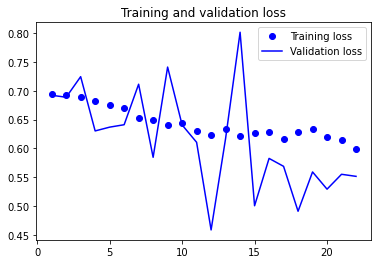

In [0]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()